In [1]:
import re
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col
import os
import pandas 
import numpy as np

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("review_and_category_analytics") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

## Diabetes Data

In [2]:
# READ IN DIABETES DATA SET
df_diabetes = pandas.read_excel('diabetes.xlsx', sheet_name = 'Total', header = 1)
sdf_diabetes = spark.createDataFrame(df_diabetes)
sdf_diabetes = sdf_diabetes.withColumn("FIPS",sdf_diabetes.FIPS.cast(IntegerType()).cast(StringType()))

# SELECT COUNTY-LEVEL DATA FOR BOTH SEXES
sdf_diabetes = sdf_diabetes \
    .filter(col("FIPS") > 56) \
    .select(["FIPS", *[col(c).alias(c[12:16]) for c in df_diabetes.columns if 'Both' in c and 'Prevalence' in c]])

In [3]:
# MISSING DATA: 
missing = sdf_diabetes.agg(*[
    (1 - (f.count(c) / f.count('*'))).alias(c + '_missing')
    for c in sdf_diabetes.columns
])

missing = missing.select(*[c for c in missing.columns if '_missing' in c])

missing.show() # NO MISSING DATA

+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|FIPS_missing|1999_missing|2000_missing|2001_missing|2002_missing|2003_missing|2004_missing|2005_missing|2006_missing|2007_missing|2008_missing|2009_missing|2010_missing|2011_missing|2012_missing|
+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|         0.0|
+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+



In [4]:
# CORRELATION MATRIX BETWEEN DIABETES DATA COLS

cols = sdf_diabetes.columns[1:] # don't use fips

num_cols = len(cols)
corr_mat = np.zeros(shape=(num_cols, num_cols))

for i, col in enumerate(cols):
    corr_mat[i][i] = 1
    for j in range(i + 1, len(cols)):
        corr = sdf_diabetes.corr(col, cols[j])
        corr_mat[i][j] = corr
        corr_mat[j][i] = corr

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(19, 15))
plt.matshow(corr_mat)
plt.xticks(range(num_cols), sdf_diabetes.columns[1:], fontsize=14, rotation=45, rotation_mode="anchor", ha="left")
plt.yticks(range(num_cols), sdf_diabetes.columns[1:], fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
fig.set_facecolor('w')
plt.savefig("corr.png", bbox_inches='tight')

In [5]:
# order 5 moving average centered around 2010 ("year of census")
sdf_diabetes = sdf_diabetes \
    .withColumn("Diabetes", (f.col("2008") + f.col("2009") + f.col("2010") + f.col("2011") + f.col("2012")) / f.lit(5)) \
    .select("FIPS", "Diabetes")

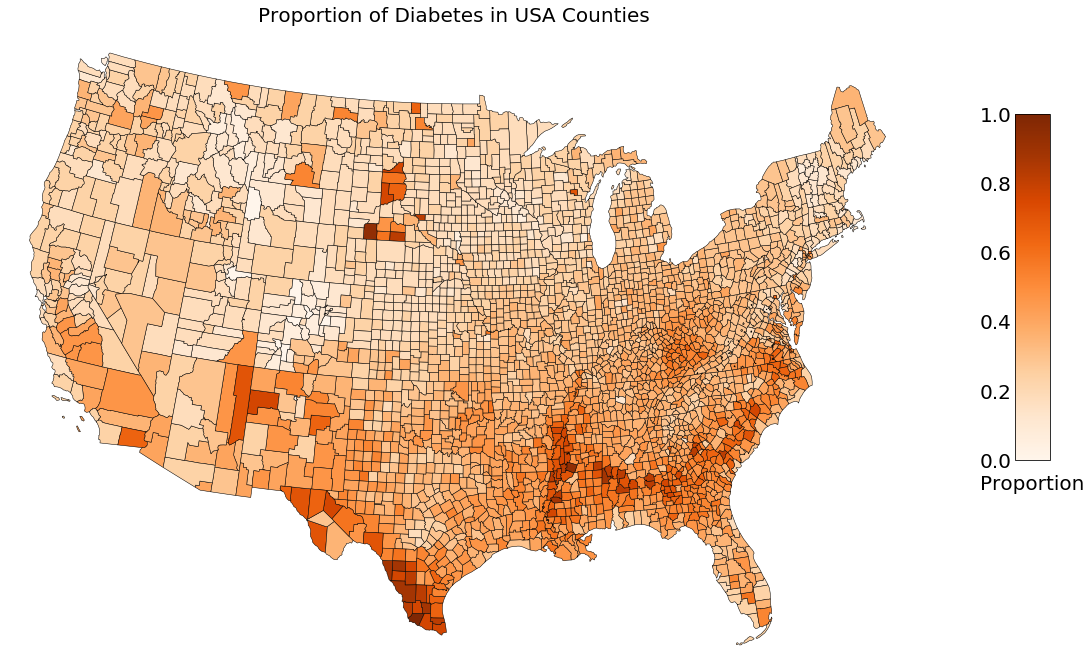

In [6]:
# CHOROPLETH MAP
usa_map_data = pandas.read_json("counties.json")

import geopandas as gpd
usa_map = gpd.GeoDataFrame \
    .from_features(usa_map_data["features"]) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 + y_0=0 +datum=NAD83 +units=m +no_defs")

usa_map = usa_map.assign(FIPS=[int(g) for g in usa_map["GEOID"]])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16))
ax.set_xlim([-0.235e7, 0.22e7])
ax.set_ylim([-1.75e6, 1.45e6])

palette = plt.get_cmap("Oranges")

diabetes_df = sdf_diabetes.select("FIPS", "Diabetes").toPandas().astype("int32")

usa_map.merge(diabetes_df, on="FIPS") \
    .plot(column="Diabetes", cmap=palette, edgecolor="black", ax=ax, linewidth=0.5)

ax.set_axis_off()
fig.set_facecolor("white")

plt.title("Proportion of Diabetes in USA Counties", size=20)
cax = fig.add_axes([1, 0.4, 0.03, 0.3])
sm = plt.cm.ScalarMappable(cmap="Oranges")
cb = plt.colorbar(sm, cax=cax)
cb.ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=20)
cb.ax.tick_params(size=0)
cb.ax.set_xlabel("Proportion", labelpad=15, size=20)
plt.savefig("diabetes.png", bbox_inches='tight')

## Food Data

In [7]:
# READ IN FOOD DATA
df_food = pandas.read_excel('food.xlsx', sheet_name = "Food Access Research Atlas", converters = {"CensusTract":str},header=0)
df_food['CensusTract'] = df_food['CensusTract'].map(lambda x: int(str(x)[:5]))

# CONVERT TO SPARK DATAFRAME
def to_spark_type(col_name: str, t: str):
    if t == "int64":
        return StructField(col_name, IntegerType(), True)
    if t == "float64":
        return StructField(col_name, FloatType(), True)
    if t == "object":
        return StructField(col_name, StringType(), True)

    return None

sortedStructList = [to_spark_type(col_name, t) for col_name, t in zip(df_food.columns, df_food.dtypes)]
sortedStructList[0] = StructField("CensusTract", StringType(),True)
sdf_food = spark.createDataFrame(df_food, StructType(sortedStructList))

# DROP COUNT DATA COLUMNS FOR THE PCT VERSIONS
sdf_food = sdf_food.drop(*[c for c in df_food.columns[31:134] if "share" not in c])

columns_to_rm = ["Urban", "GroupQuartersFlag", "LILATracts_1And10", "LILATracts_halfAnd10", "LILATracts_1And20", "LAhalfand10", "LA1and20", 
          "LILATracts_Vehicle", "HUNVFlag", "LA1and10", "LAhalfand10", "LA1and20", "LATracts_half", "LATracts1", "LATracts10", "LATracts20", 
          "LATractsVehicle_20"]
sdf_food = sdf_food.drop(*[i for i in sdf_food.columns if i in columns_to_rm])

# I'm not sure if you want these removed ?
# columns_to_rm = ['OHU2010', 'NUMGQTRS', 'PCTGQTRS', 'LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome']
# sdf_food = sdf_food.drop(*[i for i in sdf_food.columns if i in columns_to_rm])

sdf_food = sdf_food.drop(*[c for c in sdf_food.columns if 'share' in c])

In [8]:
# No missing data in food:
missing = sdf_food.agg(*[
    (1 - (f.count(c) / f.count('*'))).alias(c + '_missing')
    for c in sdf_food.columns
])

missing = missing.select(*[c for c in missing.columns if '_missing' in c])

missing.show()

+-------------------+-------------+--------------+---------------+---------------+----------------+----------------+-----------------------+-------------------+--------------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+-----------------+-----------------+--------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+---------------------+-----------------+-----------------+
|CensusTract_missing|State_missing|County_missing|POP2010_missing|OHU2010_missing|NUMGQTRS_missing|PCTGQTRS_missing|LowIncomeTracts_missing|PovertyRate_missing|MedianFamilyIncome_missing|LAPOP1_10_missing|LAPOP05_10_missing|LAPOP1_20_missing|LALOWI1_10_missing|LALOWI05_10_missing|LALOWI1_20_missing|TractLOWI_missing|TractKids_missing|TractSeniors_missing|TractWhite_missing|TractBlack_missing|TractAsian_missing|TractNHOPI_missing|TractAIAN_missing|TractOMultir_missi

#### County Level Aggregation

In [8]:
# AGGREGATE TO COUNTY WIDE
sdf_food_county = sdf_food \
    .dropna() \
    .groupby(["CensusTract", "State","County"]) \
    .agg(
        f.sum(f.col("POP2010")).alias("Pop"),
        # Weighted average of MedianFamilyIncome and Povert Rate:
        ( f.sum(f.col("MedianFamilyIncome") * f.col("POP2010")) / f.sum("POP2010") ).alias("MedianFamilyIncome"),
        ( f.sum(f.col("PovertyRate") * f.col("POP2010")) / f.sum("POP2010") ).alias("PovertyRate"),
        # Per county population of remaining columns:
        *[  
            ( (f.sum(f.col(c))) / f.sum(f.col("POP2010")) ).alias(c)
            for c in sdf_food.columns[4:] if c not in ["MedianFamilyIncome", "PovertyRate"] 
        ]
    )

#### join diabetes with food data

In [9]:
df = sdf_diabetes.join(sdf_food_county, (sdf_food_county.CensusTract == sdf_diabetes.FIPS), 'left').dropna().cache()

## Median Family Income

In [10]:
# read in state wide median family incomes
df_mfi = pandas.read_excel('list3 (1).xls', sheet_name = 'MedianFamilyIncome2010', header = 0)

schema = StructType([
    StructField(c, StringType(), True)
    for c in df_mfi.columns
])

sdf_mfi = spark.createDataFrame(df_mfi, schema)
sdf_mfi = sdf_mfi \
    .select(
        f.col('STATE').alias("State_1"), 
        f.col('TOTAL').alias("Statewide_MFI")
    ) \
    .filter("State_1 <> 'US' AND State_1 <> 'District of Columbia' AND State_1 <> 'NaN'")

#### Join diabetes/food with food desert classification:

In [11]:
food_deserts = df \
    .join(sdf_mfi, (df.State == sdf_mfi.State_1), 'left') \
    .withColumn("Food Desert", 
        ( (f.col("TractLOWI") > 0.2) | (f.col("MedianFamilyIncome") <= (0.8 * f.col("Statewide_MFI"))) )
        & (f.col("LAPOP1_10") > 0.33) 
    ) \
    .drop("State_1", "Statewide_MFI") \
    .dropna()

In [12]:
# Urban / Rural CODES (1 = most urban; 9 = most rural)
df_urbanity = pandas.read_excel('ruralurbancodes2013.xls', sheet_name = 'Rural-urban Continuum Code 2013', header = 0)

schema = StructType([StructField(str(i), StringType(), True) for i in df_urbanity.columns])
sdf_urbanity = spark.createDataFrame(df_urbanity, schema) \
    .select("FIPS", "RUCC_2013") \
    .withColumn("RUCC_2013", f.col("RUCC_2013").cast(IntegerType()))

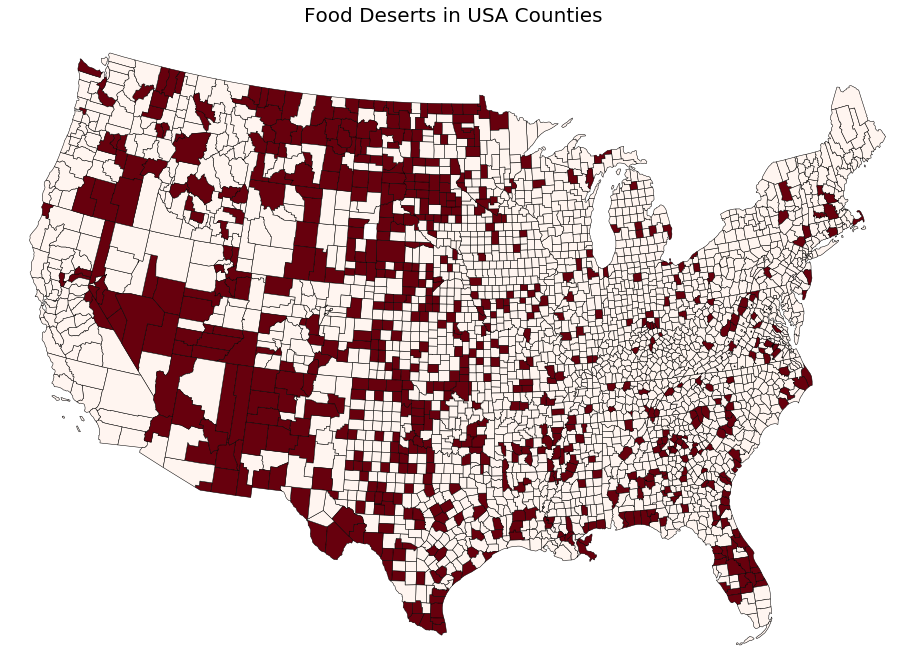

In [13]:
# CHOROPLETH MAP
usa_map_data = pandas.read_json("counties.json")

import geopandas as gpd
usa_map = gpd.GeoDataFrame \
    .from_features(usa_map_data["features"]) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 + y_0=0 +datum=NAD83 +units=m +no_defs")

usa_map = usa_map.assign(FIPS=[int(g) for g in usa_map["GEOID"]])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16))
ax.set_xlim([-0.235e7, 0.22e7])
ax.set_ylim([-1.75e6, 1.45e6])

map_data = food_deserts \
    .select("FIPS", "Food Desert") \
    .toPandas() \
    .astype("int64")

merged_map = usa_map.merge(map_data, on="FIPS", how="left")
#merged_map["Food Desert"] = [("Not a Food Desert" if fd else "Food Desert") for fd in merged_map["Food Desert"]]
choro = merged_map.plot(
    column="Food Desert", 
    categorical=True, 
    cmap="Reds", 
    edgecolor="black", 
    ax=ax, 
    linewidth=0.5, 
    legend_kwds={'fontsize':16},
)

ax.set_axis_off()
fig.set_facecolor("white")

#plt.legend(handles=ax.get_legend().legendHandles, labels=["Not a Food Desert", "Food Desert"])

plt.title("Food Deserts in USA Counties", size=20)

plt.savefig("food_deserts.png", bbox_inches='tight')

#### Change 'food_deserts' to 'df' for later simplicity:

In [24]:
df = food_deserts \
    .drop("FIPS", "CensusTract", "State", "County", 'NUMGQTRS', 'LowIncomeTracts')

#### Variables being used:

In [25]:
print(df.columns)

['Diabetes', 'Pop', 'MedianFamilyIncome', 'PovertyRate', 'OHU2010', 'PCTGQTRS', 'LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 'LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP', 'Food Desert']


## Linear Regression:

In [16]:
from pyspark.ml.regression import LinearRegression

# can use place some of the data preprocessing in the pipeline

assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features") 
transformed = assembler.transform(df)
df1 = transformed.selectExpr("Diabetes as label", "features as features")
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)
scaler = standardScaler.fit(df1)
scaled_df = scaler.transform(df1)

seed = 314
train_test = [0.7, 0.3]
train_data, test_data = df1.randomSplit(train_test, seed=seed)

# parameters are the same from the documentation
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

pipeline = Pipeline(stages=[standardScaler, lr])

# Set up the parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator())

cvModel = crossval.fit(train_data)
prediction = cvModel.transform(test_data)
selected = prediction.select("prediction", "label", "features") # the prediction has several columns

In [17]:
# Gives best parameters for the linear regression model
bestModel = cvModel.bestModel.stages[-1]

print(
    bestModel._java_obj.getRegParam(),
    bestModel._java_obj.getElasticNetParam(),
    bestModel._java_obj.getFitIntercept()
)

0.01 0.0 True


In [18]:
# Coefficients of the features for linear regression
lr = LinearRegression(maxIter=10, regParam=0.01, elasticNetParam=0.0)
lr_model = lr.fit(train_data)
for i in range(len(lr_model.coefficients)):
    print(str(df.columns[i+1]) + ': ' + str(lr_model.coefficients[i]))

Pop: -1.6508405858204117e-07
MedianFamilyIncome: -4.143395802157108e-05
PovertyRate: 0.02042115319192484
OHU2010: -23.821755212765094
NUMGQTRS: -7.779215710510451
PCTGQTRS: 1435.8925898778627
LAPOP1_10: 1.0525817566416467
LAPOP05_10: -0.22764774935786397
LAPOP1_20: 0.7927708590221106
LALOWI1_10: 0.16434157335082192
LALOWI05_10: -2.378878060013245
LALOWI1_20: -1.4977199760111282
TractLOWI: 2.5434038410415467
TractKids: -7.7101691828118515
TractSeniors: 0.7047450409742573
TractWhite: -2.7548426506211117
TractBlack: 5.30193869789423
TractAsian: -3.2927113301769255
TractNHOPI: 16.52005875257974
TractAIAN: 0.7747904381975051
TractOMultir: -14.4716876123928
TractHispanic: 7.377276334070157
TractHUNV: 1.1219742163682487
TractSNAP: 18.813301581279266
Food Desert: -0.13907639401512834


In [19]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
model = pipeline.fit(train_data)
treeModel = model.stages[1]

print(treeModel)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(prediction)
print("R^2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 0.915158
LinearRegressionModel: uid=LinearRegression_432cac3157af, numFeatures=25
R^2 on test data = 0.863492


## Decision Tree w PCA:

In [20]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor

In [22]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df1)

pca = PCA(k=3, inputCol="features_scaled", outputCol="pcaFeatures")
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[scaler, featureIndexer, pca, dt])
model = pipeline.fit(train_data)

predictions = model.transform(test_data)
predictions.select("prediction", "label", "features").show(5)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]

print(treeModel)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R^2 on test data = %g" % r2)

treeModel = model.stages[1]

print(treeModel)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|12.553234567901235|            10.606|[23530.0,71324.03...|
|12.576553359683796|            10.842|[2778.0,49583.0,1...|
|12.553234567901235|11.475999999999999|[1059.0,59688.0,9...|
|14.839988372093021|12.068000000000001|[1556.0,45000.0,2...|
|12.576553359683796|            12.528|[21403.0,58105.01...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.25419
VectorIndexerModel: uid=VectorIndexer_743196a64cb3, numFeatures=25, handleInvalid=error
R^2 on test data = 0.743614
VectorIndexerModel: uid=VectorIndexer_743196a64cb3, numFeatures=25, handleInvalid=error


## Random Forest

In [26]:
rf = RandomForestRegressor(featuresCol="indexedFeatures")
pipeline = Pipeline(stages=[featureIndexer, rf])

model = pipeline.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % r2)

# Make predictions.
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

r2 = evaluator.evaluate(predictions)
print("R^2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 0.743614
R^2 on test data = 0.821516
